In [1]:
#### Create Plots based on OSCAR xml files ####
# analysis of specific variables

# used python version 3.10.6

In [2]:
import xml.etree.ElementTree as ET
import urllib.request
import csv
import requests
from bs4 import BeautifulSoup
from urllib.request import urlopen
import json
import re
import os
import pandas as pd

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import pandas as pd
import matplotlib.lines as mlines

In [143]:
from urllib.request import urlopen
from bs4 import BeautifulSoup

id = "0-20008-0-MKN"

url = "https://oscar.wmo.int/oai/provider?verb=GetRecord&metadataPrefix=wmdr&identifier=%20" + id
xml = urlopen(url).read()
soup = BeautifulSoup(xml, 'xml')

# Retrieve all of the anchor tags
tags = soup('OAI-PMH')
# print(tags)



In [144]:
%%capture cap --no-stderr
print(tags)

In [145]:
with open(os.getcwd()+"/Files/File_"+id+".txt", 'w') as f:
    f.write(cap.stdout)

In [146]:
df = pd.DataFrame(np.nan, index=[0],columns=["beginPosition", "endPosition", "station", "variable"])
# df = pd.DataFrame()
print("1: ", df)

new_row = {"beginPosition":1,"endPosition":2,"station":"NRB","variable":43}
df.loc[len(df)] = new_row 
print("2: ", df)


1:     beginPosition  endPosition  station  variable
0            NaN          NaN      NaN       NaN
2:     beginPosition  endPosition station  variable
0            NaN          NaN     NaN       NaN
1            1.0          2.0     NRB      43.0


In [150]:
# get variables at a station

f = open(os.getcwd()+'/stations.json')
data = json.load(f)

df = pd.DataFrame(data["stations"])
df["observedProperties_unique"] = range(0,len(df))
pd.options.mode.chained_assignment = None

from functools import reduce
 
def unique(list1):
    # Print directly by using * symbol
    ans = reduce(lambda re, x: re+[x] if x not in re else re, list1, [])
    return(ans)

for i in range(0,len(df)):
    unique_codes = unique(df["observedProperties"][i])
    df["observedProperties_unique"][i] = unique_codes

variables = df[df["wigosId"]==id]["observedProperties_unique"].tolist()
f=open('/home/sdanioth/Documents/git/OSCAR_analysis/Files/File_'+id+'.txt')
lines=f.readlines()
all_dates = []

# prepare data frame #
df_station = pd.DataFrame(np.nan, index=[0],columns=["beginPosition", "endPosition", "station", "variable"])

for var in range(0,len(variables[0])):
    variable = variables[0][var]
    station = id

    # find line numbers containing the WMDR number of the observed property
    numbers = []

    with open('/home/sdanioth/Documents/git/OSCAR_analysis/Files/File_'+id+'.txt') as myFile:
        for num, line in enumerate(myFile, 1):
            if variables[0][var] in line:
                numbers.append(num)

    # find the line numbers with <om:observedProperty
    obs = "observedProperty"
    numbers_obs = []

    for n in numbers:
        if obs in lines[n-1]:
            numbers_obs.append(n)

    ### read 20 lines before "observedProperty" line to get "beginPosition" (& "endPosition")
    for n in numbers_obs:
        start = "beginPosition"
        end = "endPosition"
        line_numbers = range(n-20,n)

        f=open('/home/sdanioth/Documents/git/OSCAR_analysis/Files/File_'+id+'.txt')
        lines=f.readlines()
        positions = []

        for n in line_numbers:
            if start in lines[n]:
                beginning = re.findall(r'\d{4}-\d{2}-\d{2}',lines[n])
                if beginning:
                    pd.to_datetime(beginning, format='%Y-%m-%d')
                    positions.append(beginning[0])
                else:
                    positions.append(np.nan)
                    
            elif end in lines[n]:
                ending = re.findall(r'\d{4}-\d{2}-\d{2}',lines[n])
                if ending:
                    pd.to_datetime(ending, format='%Y-%m-%d')
                    positions.append(ending[0])
                else:
                    positions.append(pd.Timestamp.today().strftime("%Y-%m-%d"))

        beginPosition  = positions[0]
        endPosition = positions[1]
        new_row = {"beginPosition":beginPosition,"endPosition":endPosition,"station":station,"variable":variable}
        df_station.loc[len(df_station)] = new_row 

    
df_station.drop([0], axis=0, inplace=True)
print(df_station)



   beginPosition endPosition        station variable
1     1999-01-01  2023-10-20  0-20008-0-MKN      248
2     2003-12-01  2011-06-21  0-20008-0-MKN      192
3     2003-12-01  2011-06-21  0-20008-0-MKN      194
4     2003-12-01  2011-06-21  0-20008-0-MKN      195
5     2003-12-01  2011-06-21  0-20008-0-MKN      196
6     1999-01-01  2023-10-20  0-20008-0-MKN      201
7     1999-01-01  2023-10-20  0-20008-0-MKN      203
8     1999-01-01  2023-10-20  0-20008-0-MKN      251
9     1999-01-01  2023-10-20  0-20008-0-MKN      205
10    2002-05-01  2010-08-01  0-20008-0-MKN      262
11    1999-01-01  2023-10-20  0-20008-0-MKN      216
12    2021-09-01  2023-10-20  0-20008-0-MKN      216
13    2002-05-31  2006-05-31  0-20008-0-MKN      284
14    1999-01-01  2023-10-20  0-20008-0-MKN      284
15    2003-12-01  2011-06-21  0-20008-0-MKN      284
16    2017-01-26  2023-10-20  0-20008-0-MKN      224
17    1999-01-01  2023-10-20  0-20008-0-MKN      224
18    1999-01-01  2023-10-20  0-20008-0-MKN   

In [151]:
# combine 3 dictionaries (Atmosphere, Ocean & Terrestrial)

with open(os.getcwd()+'/WMDR_dictionaries/'+"ObservedVariableAtmosphere_WMDR"+'_dictionary.json') as f:
    dictionary = json.loads(f.read())


with open(os.getcwd()+'/WMDR_dictionaries/'+"ObservedVariableOcean_WMDR"+'_dictionary.json') as f:
    dictionary_Ocean = json.loads(f.read())   

dictionary.update(dictionary_Ocean)

with open(os.getcwd()+'/WMDR_dictionaries/'+"ObservedVariableTerrestrial_WMDR"+'_dictionary.json') as f:
    dictionary_Terrestrial = json.loads(f.read())

dictionary.update(dictionary_Terrestrial)

variables = df_station["variable"]

df_station["variables_names"] = [(list(dictionary.keys())[list(dictionary.values()).index(str(vari))]) for vari in variables]
df_station


,beginPosition,endPosition,station,variable,variables_names
1,1999-01-01,2023-10-20,0-20008-0-MKN,248,"Transport calculations (e.g., trajectories)"
2,2003-12-01,2011-06-21,0-20008-0-MKN,192,CH4 (methane)
3,2003-12-01,2011-06-21,0-20008-0-MKN,194,CO2 (carbon dioxide)
4,2003-12-01,2011-06-21,0-20008-0-MKN,195,"CO2 (carbon dioxide, C-13)"
5,2003-12-01,2011-06-21,0-20008-0-MKN,196,CO2 [O-18]
6,1999-01-01,2023-10-20,0-20008-0-MKN,201,N2O (nitrous oxide)
7,1999-01-01,2023-10-20,0-20008-0-MKN,203,SF6 (sulfur hexafluoride)
8,1999-01-01,2023-10-20,0-20008-0-MKN,251,Humidity (at specified distance from reference...
9,1999-01-01,2023-10-20,0-20008-0-MKN,205,H2 (hydrogen molecule)
10,2002-05-01,2010-08-01,0-20008-0-MKN,262,Surface ozone


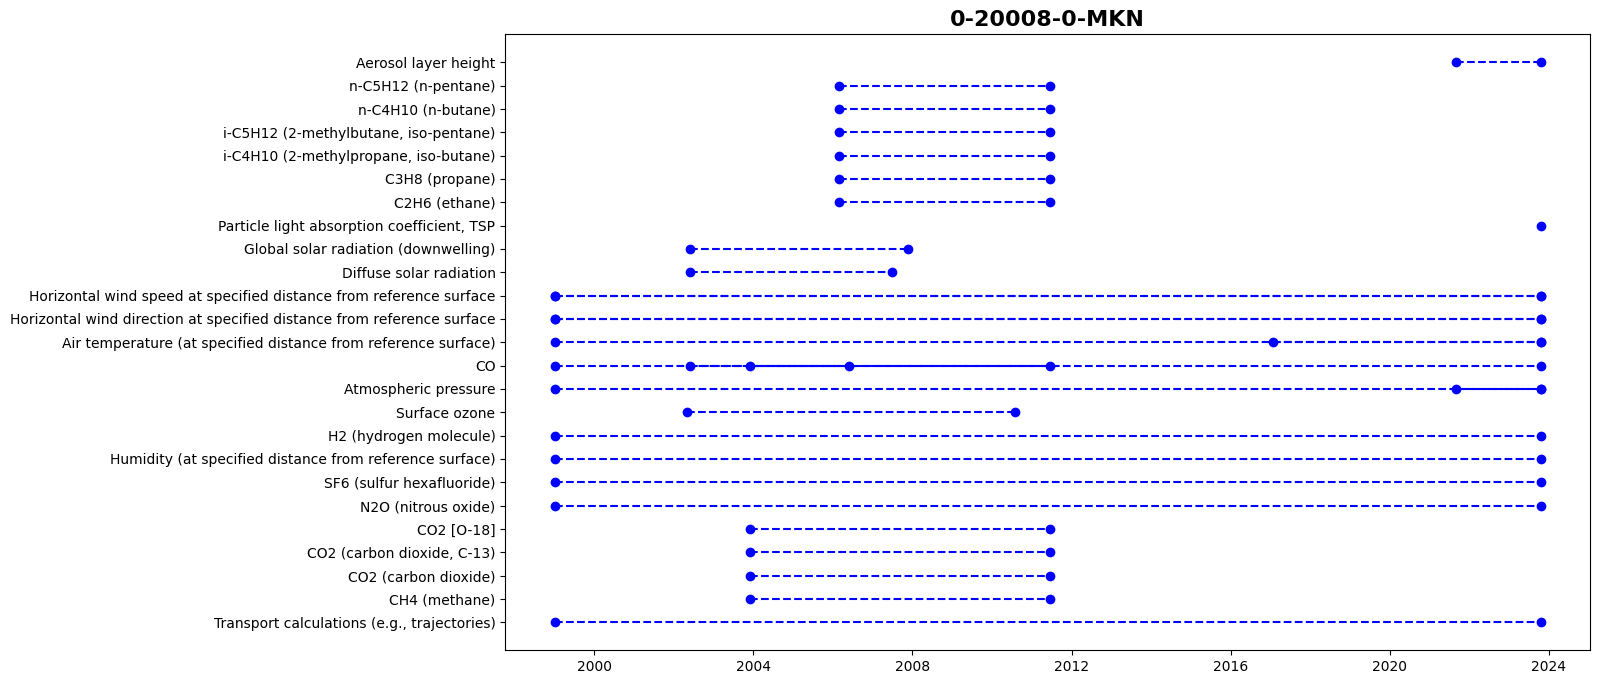

In [154]:
plt.style.use('default')
fig, axes = plt.subplots(1,1, figsize=(14,8))

variables = df[df["wigosId"]==id]["observedProperties_unique"].tolist()

for var in range(0,len(variables[0])):
    df_var = df_station[df_station["variable"]==str(variables[0][var])]

    x_values = [pd.to_datetime(df_var["beginPosition"]), pd.to_datetime(df_var["endPosition"])]
    # print(x_values)
    plt.plot(x_values, [var,var], 'bo', linestyle="--")

# print(variables)
names = []
for var in range(0,len(variables[0])):
    variable_df = df_station[df_station["variable"]==str(variables[0][var])]
    name = variable_df.iloc[0]["variables_names"]
    # print(name)
    names.append(name)
n = range(0,len(names))
plt.yticks(n,names)

# title
plt.title(id, fontsize=16, fontweight="bold")


# save figure
fig.savefig(os.getcwd()+"/Plots/Deployments_"+id+".jpeg", bbox_inches='tight')